# Homework 2, *part 2* (60 points)

In this assignment you will build a heavy convolutional neural net (CNN) to solve Tiny ImageNet image classification. Try to achieve as high accuracy as possible.

## Deliverables

* This file,
* a "checkpoint file" from `torch.save(model.state_dict(), ...)` that contains model's weights (which a TA should be able to load to verify your accuracy).

## Grading

* 9 points for reproducible training code and a filled report below.
* 12 points for building a network that gets above 20% accuracy.
* 6.5 points for beating each of these milestones on the validation set:
  * 25.0%
  * 30.0%
  * 32.5%
  * 35.0%
  * 37.5%
  * 40.0%
    
## Restrictions

* Don't use pretrained networks.

## Tips

* One change at a time: never test several new things at once.
* Google a lot.
* Use GPU.
* Use regularization: L2, batch normalization, dropout, data augmentation.
* Use Tensorboard ([non-Colab](https://github.com/lanpa/tensorboardX) or [Colab](https://medium.com/@tommytao_54597/use-tensorboard-in-google-colab-16b4bb9812a6)) or a similar interactive tool for viewing progress.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import scipy as sp
import scipy.misc

import torchvision
# import torch
from torchvision import transforms
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [0]:
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/spring2019/week03_convnets/tiny_img.py -O tiny_img.py
from tiny_img import download_tinyImg200
data_path = '.'
download_tinyImg200(data_path)

--2019-04-19 15:28:40--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/spring2019/week03_convnets/tiny_img.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3378 (3.3K) [text/plain]
Saving to: ‘tiny_img.py’

tiny_img.py         100%[===================>]   3.30K  --.-KB/s    in 0s      

2019-04-19 15:28:45 (79.9 MB/s) - ‘tiny_img.py’ saved [3378/3378]

./tiny-imagenet-200.zip


Training and validation images are now in `tiny-imagenet-200/train` and `tiny-imagenet-200/val`.

In [0]:
transform = transforms.Compose([
    transforms.RandomGrayscale(p=0.1),
    transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
#     transforms.RandomCrop(64),
    transforms.RandomRotation(45),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [0]:
# Your code here

dataset = torchvision.datasets.ImageFolder('tiny-imagenet-200/train', transform=transform)
test_dataset = torchvision.datasets.ImageFolder('tiny-imagenet-200/val', transform=transform)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [80000, 20000])
test_dataset, val_dataset = torch.utils.data.random_split(val_dataset, [10000, 10000])

In [0]:
batch_size = 50
train_batch_gen = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=6)

In [0]:
val_batch_gen = torch.utils.data.DataLoader(val_dataset, 
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=6)

torch.Size([3, 64, 64])
tensor(179)


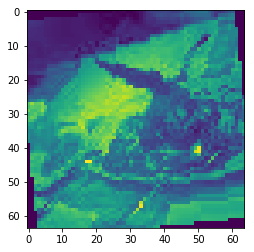

In [0]:
for X,y in train_batch_gen:
    print(X[0].shape)
    print(y[0])
    plt.imshow(np.array(X[0,0,:,:]));
    break

In [0]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [0]:
model = nn.Sequential()

model.add_module('conv1', nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1))
model.add_module('batch1', nn.BatchNorm2d(16))
model.add_module('relu1', nn.ReLU())  
model.add_module('conv2', nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1))
model.add_module('relu2', nn.ReLU())  
model.add_module('batch2', nn.BatchNorm2d(16))
model.add_module('max_pool1', nn.MaxPool2d(2, 2, padding=0))

model.add_module('conv3', nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1))
model.add_module('batch3', nn.BatchNorm2d(32))
model.add_module('relu3', nn.ReLU()) 
model.add_module('conv4', nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1))
model.add_module('batch4', nn.BatchNorm2d(32))
model.add_module('relu4', nn.ReLU()) 
model.add_module('max_pool2', nn.MaxPool2d(2, 2, padding=0))

model.add_module('conv5', nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1))
model.add_module('batch5', nn.BatchNorm2d(64))
model.add_module('relu5', nn.ReLU()) 
model.add_module('conv6', nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1))
model.add_module('batch6', nn.BatchNorm2d(64))
model.add_module('relu6', nn.ReLU()) 
model.add_module('max_pool3', nn.MaxPool2d(2, 2, padding=0))


model.add_module('conv7', nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1))
model.add_module('batch7', nn.BatchNorm2d(128))
model.add_module('relu7', nn.ReLU())  
model.add_module('conv8', nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1))
model.add_module('batch8', nn.BatchNorm2d(128))
model.add_module('relu8', nn.ReLU())
model.add_module('max_pool4', nn.MaxPool2d(2, 2, padding=0))

model.add_module('flatten', Flatten())

model.add_module('dense1', nn.Linear(2048, 1024, bias=False))  # 512*2*2
model.add_module('relu13', nn.ReLU())
model.add_module('dropout1', nn.Dropout(0.5))
model.add_module('dense2', nn.Linear(1024, 200, bias=False))

In [0]:
def compute_loss(X_batch, y_batch):
    X_batch = Variable(torch.FloatTensor(X_batch))
    y_batch = Variable(torch.LongTensor(y_batch))
    logits = model(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

In [0]:
opt = torch.optim.Adam(model.parameters(), lr=0.0001)

train_loss = []
val_accuracy = []

num_epochs = 35 # total amount of full passes over training data

import time

for epoch in range(num_epochs):
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for (X_batch, y_batch) in train_batch_gen:
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.cpu().data.numpy())

    
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in val_batch_gen:
        logits = model(Variable(torch.FloatTensor(X_batch)))
        y_pred = logits.max(1)[1].data
        val_accuracy.append(np.mean( (y_batch.cpu() == y_pred.cpu()).numpy() ))

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(train_dataset) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(val_dataset) // batch_size :]) * 100))

Epoch 1 of 35 took 1224.510s
  training loss (in-iteration): 	5.001499
  validation accuracy: 			7.25 %
Epoch 2 of 35 took 1242.262s
  training loss (in-iteration): 	4.470270
  validation accuracy: 			12.27 %
Epoch 3 of 35 took 1242.804s
  training loss (in-iteration): 	4.199828
  validation accuracy: 			14.81 %
Epoch 4 of 35 took 1261.179s
  training loss (in-iteration): 	4.015407
  validation accuracy: 			17.19 %
Epoch 5 of 35 took 1255.879s
  training loss (in-iteration): 	3.883311
  validation accuracy: 			18.66 %
Epoch 6 of 35 took 1253.844s
  training loss (in-iteration): 	3.778530
  validation accuracy: 			19.26 %
Epoch 7 of 35 took 1258.097s
  training loss (in-iteration): 	3.690774
  validation accuracy: 			20.77 %
Epoch 8 of 35 took 1246.028s
  training loss (in-iteration): 	3.614235
  validation accuracy: 			21.83 %
Epoch 9 of 35 took 1248.769s
  training loss (in-iteration): 	3.540544
  validation accuracy: 			23.25 %
Epoch 10 of 35 took 1240.212s
  training loss (in-iterat

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self

KeyboardInterrupt: ignored

Stopped the model due to the Collab session.

In [0]:
torch.save(model.state_dict(), 'Checkpoint.pth')

In [0]:
state_dict = torch.load('Checkpoint.pth')
model.load_state_dict(state_dict)

In [12]:
opt = torch.optim.Adam(model.parameters(), lr=0.0001)

train_loss = []
val_accuracy = []

num_epochs = 15 # total amount of full passes over training data

import time

for epoch in range(num_epochs):
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for (X_batch, y_batch) in train_batch_gen:
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.cpu().data.numpy())

    
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in val_batch_gen:
        logits = model(Variable(torch.FloatTensor(X_batch)))
        y_pred = logits.max(1)[1].data
        val_accuracy.append(np.mean( (y_batch.cpu() == y_pred.cpu()).numpy() ))

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(train_dataset) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(val_dataset) // batch_size :]) * 100))

Epoch 1 of 15 took 1212.931s
  training loss (in-iteration): 	2.872272
  validation accuracy: 			37.71 %
Epoch 2 of 15 took 1220.260s
  training loss (in-iteration): 	2.843887
  validation accuracy: 			38.00 %
Epoch 3 of 15 took 1259.606s
  training loss (in-iteration): 	2.810568
  validation accuracy: 			37.43 %
Epoch 4 of 15 took 1257.793s
  training loss (in-iteration): 	2.787693
  validation accuracy: 			37.94 %
Epoch 5 of 15 took 1259.672s
  training loss (in-iteration): 	2.766222
  validation accuracy: 			37.47 %
Epoch 6 of 15 took 1257.370s
  training loss (in-iteration): 	2.751547
  validation accuracy: 			37.23 %
Epoch 7 of 15 took 1237.180s
  training loss (in-iteration): 	2.732216
  validation accuracy: 			37.84 %
Epoch 8 of 15 took 1205.719s
  training loss (in-iteration): 	2.700253
  validation accuracy: 			37.61 %
Epoch 9 of 15 took 1218.860s
  training loss (in-iteration): 	2.697625
  validation accuracy: 			37.44 %
Epoch 10 of 15 took 1199.664s
  training loss (in-itera

In [0]:
torch.save(model.state_dict(), 'CheckpointFinal.pth')

In [0]:
state_dict = torch.load('CheckpointFinal.pth')
model.load_state_dict(state_dict)

When everything is done, please compute accuracy on the validation set and report it below.

# Report

Below, please mention

* a brief history of tweaks and improvements;
* what is the final architecture and why?
* what is the training method (batch size, optimization algorithm, ...) and why?
* Any regularization and other techniques applied and their effects;

The reference format is:

*"I have analyzed these and these articles|sources|blog posts, tried that and that to adapt them to my problem and the conclusions are such and such".*

Part 1.

At the beginning, I simply applied the model from the seminar week 2 and run until 10 iterations. It did not include any convolutional layers. The obtained val score was 9.42% at 10 epoch, which obviously was not satisfactory, yet trained relatively fast as compared to subsequent models (~200 s/epoch).

On the second trial, I applied 2 convolutional layers and max pool while not changing anything from the seminar's model. After epoch 10, val accuracy could not get higher than 16.77%.

On the third trial, I applied data augmentation by adding normalization. The result did not change significantly.

Then, I applied one more layer, where each convolution increases output relative to input channels. Thus, the last convolution had 128 output channels, and after each convolution there was a batch normalization and then ELU. The obtained val score could reach 21% at 10th epoch, however each iteration took 900 s/epoch on Collab with GPU option turned on.

On the fith trial, architecture which distantly resembles VGGNet was created with 12 convolutional layers, which took a lot of time to train (~ 12 hours). The highest val score was 29.83% at epoch 8. However, the score did not improve and I stopped training the model at 32st epoch due to overfitting.

To cope with long training time and overfitting, I applied more image transformations and reduced output channels for convolutional layers for the next trial. One important change was a switch from SGD optimizer to Adam optimizer. Particularly, the next models had 8 convolutional layers, image transofmations included random rotations, flips, and grayscale. As the result, the val score was lower than the previous model, yet no overfitting was registered. To explain the validation accuracy reduction, the precious model was more architecturally complex than the subsequent trials. For example, the first epoch for the "fith" model was 16%, while subsequent ones had around 6%. In addition, I converted images to grayscale, and it reduced computational time while increased validation error.

Finally, this update contains a final model with a bunch of image transformations, tweaked 8 convolutional layers, and it could achieve 38%.

Part 2 (UPD).

The final model (as it here) was based on VGGNet because of uniform architecture and becuase of its easiness of applicability. Also, I analyzed an article on Medium by Siddharth Das, where he compares all known CNN architectures. According to the article, VGGNet is good at extracting features from images and serves as a baseline extracting patterns, which is a relevant task for the assignment. I also analyzed a VGGNet architecture from Pytorch Forum by shaqdc1, and I did it in a similar way.

Looking into the model, it has a total 8 convolutional layers. One "block" starts with the first conv. layer with input channel less than output channel, and after such every conv. layer there are batch normalization and activation function. The next convolutional layers have the same input and output channels to widen the convolution block. The last part of the block is a maxpool layer.

Part 3  & 4 ( UPD). 

I kept batch size of 50 as from the seminar since it occured to be optimal for my model based on subsequent trials. Speaking about activations, I kept ReLU as default since no significant impact on accuracy were shown by other types of activations. For the final model, I changed SGD optimization to Adam becuase of its known good performance. Also, I added normalization, random vertica and horizontal flips, rotations for transforming images, which helped my model to ovoid overfitting.






